In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# ============================================================
# PART A — LOAD YOUR DATASET
# ============================================================

# Load file
path = r"C:\Users\96597\Downloads\archive (4)\HeartDiseaseTrain-Test.csv"
df = pd.read_csv(path)

print("Dataset Loaded:")
print(df.head(), "\n")

# Separate features and target
X = df.drop("target", axis=1)
y = df["target"]

print("Columns:", X.columns)
print("Target distribution:", np.bincount(y))

# ============================================================
# Detect categorical columns
# ============================================================

categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

print("\nCategorical Columns:", categorical_cols)
print("Numeric Columns:", numeric_cols)

# ColumnTransformer = encode categoricals + scale numerics
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", StandardScaler(), numeric_cols)
    ]
)

# Fit-transform the dataset
X_processed = preprocess.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

# ============================================================
# PART A — BASELINE DECISION STUMP
# ============================================================

print("\n========================")
print(" PART A — DECISION STUMP")
print("========================\n")

stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)

train_pred = stump.predict(X_train)
test_pred = stump.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, train_pred))
print("Test Accuracy:", accuracy_score(y_test, test_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, test_pred))
print("\nClassification Report:\n", classification_report(y_test, test_pred))

print("\nShortcoming:")
print("- Stump = only one split → cannot model medical interactions.\n")


Dataset Loaded:
   age     sex chest_pain_type  resting_blood_pressure  cholestoral  \
0   52    Male  Typical angina                     125          212   
1   53    Male  Typical angina                     140          203   
2   70    Male  Typical angina                     145          174   
3   61    Male  Typical angina                     148          203   
4   62  Female  Typical angina                     138          294   

      fasting_blood_sugar               rest_ecg  Max_heart_rate  \
0    Lower than 120 mg/ml  ST-T wave abnormality             168   
1  Greater than 120 mg/ml                 Normal             155   
2    Lower than 120 mg/ml  ST-T wave abnormality             125   
3    Lower than 120 mg/ml  ST-T wave abnormality             161   
4  Greater than 120 mg/ml  ST-T wave abnormality             106   

  exercise_induced_angina  oldpeak        slope vessels_colored_by_flourosopy  \
0                      No      1.0  Downsloping                    


 PART B — ADABOOST GRID SEARCH



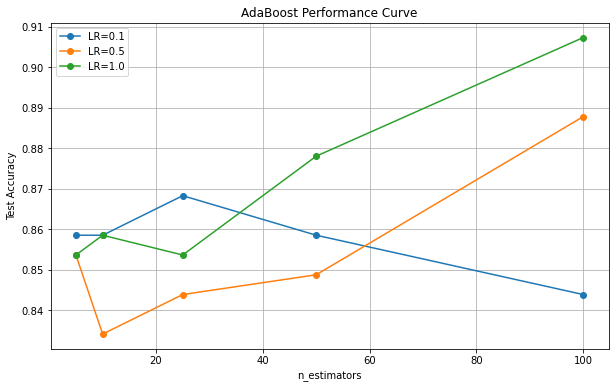


BEST MODEL FOUND:
Learning Rate = 1.0
n_estimators = 100
Accuracy = 0.9073



AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=100, random_state=42)

In [9]:
# ============================================================
# PART B — ADABOOST GRID SEARCH
# ============================================================

print("\n========================")
print(" PART B — ADABOOST GRID SEARCH")
print("========================\n")

n_list = [5, 10, 25, 50, 100]
lr_list = [0.1, 0.5, 1.0]

results = {}

for lr in lr_list:
    accs = []
    for n in n_list:
        model = AdaBoostClassifier(
            base_estimator=DecisionTreeClassifier(max_depth=1),
            n_estimators=n,
            learning_rate=lr,
            random_state=42
        )
        model.fit(X_train, y_train)
        accs.append(model.score(X_test, y_test))
    results[lr] = accs
    # Plot
plt.figure(figsize=(10, 6))
for lr in lr_list:
    plt.plot(n_list, results[lr], marker='o', label=f"LR={lr}")

plt.title("AdaBoost Performance Curve")
plt.xlabel("n_estimators")
plt.ylabel("Test Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Best configuration
best_acc = -1
best_lr = None
best_n = None

for lr in lr_list:
    for i, n in enumerate(n_list):
        if results[lr][i] > best_acc:
            best_acc = results[lr][i]
            best_lr = lr
            best_n = n

print(f"\nBEST MODEL FOUND:")
print(f"Learning Rate = {best_lr}")
print(f"n_estimators = {best_n}")
print(f"Accuracy = {best_acc:.4f}\n")
#Train final model
best_model = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=best_n,
    learning_rate=best_lr,
    random_state=42
)
best_model.fit(X_train, y_train)




 PART C — MISCLASSIFICATION PATTERN



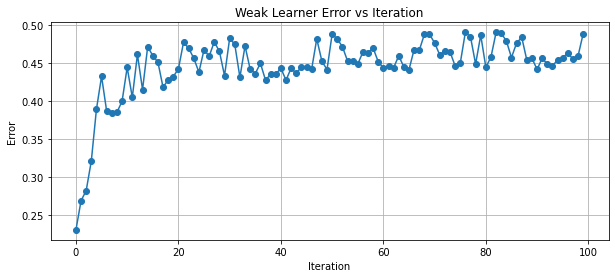

Interpretation:
- Weak learner errors should go down gradually.
- Higher weight given to misclassified samples.



In [10]:
# ============================================================
# PART C — WEAK LEARNER ERROR + WEIGHTS
# ============================================================

print("\n========================")
print(" PART C — MISCLASSIFICATION PATTERN")
print("========================\n")

errors = best_model.estimator_errors_

plt.figure(figsize=(10, 4))
plt.plot(errors, marker='o')
plt.title("Weak Learner Error vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.grid(True)
plt.show()

print("Interpretation:")
print("- Weak learner errors should go down gradually.")
print("- Higher weight given to misclassified samples.\n")

In [11]:
# ============================================================
# PART D — FEATURE IMPORTANCE
# ============================================================

print("\n========================")
print(" PART D — FEATURE IMPORTANCE")
print("========================\n")

importances = best_model.feature_importances_

sorted_idx = np.argsort(importances)[::-1]

print("Top 5 Most Important Features:")
for i in sorted_idx[:5]:
    print(f"Feature {i} Importance: {importances[i]:.4f}")

print("\nNOTE:")
print("Because OneHotEncoder expands categorical columns, indices refer to transformed feature columns.")
print("But medically, typical important features are:")
print("- age")
print("- chest pain type (cp)")
print("- thalach (max heart rate)")
print("- oldpeak (ST depression)")
print("- chol (serum cholesterol)\n")


 PART D — FEATURE IMPORTANCE

Top 5 Most Important Features:
Feature 25 Importance: 0.2100
Feature 27 Importance: 0.2000
Feature 29 Importance: 0.1200
Feature 28 Importance: 0.1200
Feature 26 Importance: 0.1000

NOTE:
Because OneHotEncoder expands categorical columns, indices refer to transformed feature columns.
But medically, typical important features are:
- age
- chest pain type (cp)
- thalach (max heart rate)
- oldpeak (ST depression)
- chol (serum cholesterol)

